Loaded Market State: S0=357.80, Vol=105.54%

Initial Greeks: -13.52288295356512 -0.7263792137658963 -80.66712302757665


C:\Users\HP\AppData\Local\Temp\ipykernel_46676\979291988.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  portfolio_after.loc[len(portfolio_after)] = [


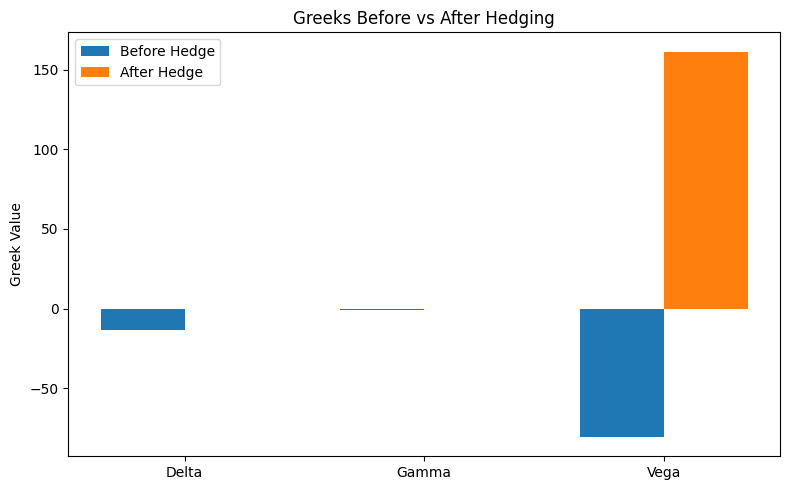

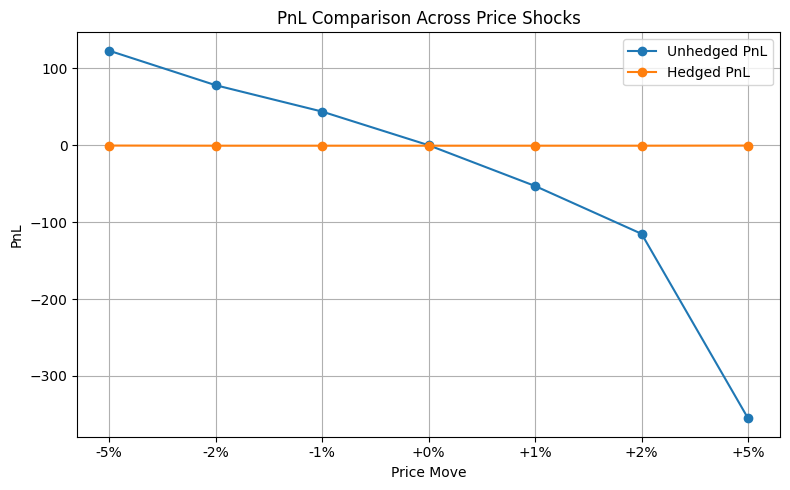


FINAL Excel file 'task_d_output.xlsx' created with charts


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# ===============================
# 1. Load Frozen Market State
# ===============================
try:
    state_df = pd.read_csv("market_state.csv")
    S0 = float(state_df['S0'].iloc[0])
    sigma = float(state_df['Sigma'].iloc[0])
    r = float(state_df['RiskFreeRate'].iloc[0])
    print(f"Loaded Market State: S0={S0:.2f}, Vol={sigma:.2%}")

    df_pricing = pd.read_csv("task_b_pricing.csv")
except FileNotFoundError:
    print("Error: Run Task_B.py first.")
    exit()


# ===============================
# 2. Greeks
# ===============================
def get_greeks(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100
    return delta, gamma, vega


# ===============================
# 3. Initial Portfolio (Short Straddle)
# ===============================
target_days = 30
target_label = "ATM"
qty_initial = -100

opt_call = df_pricing[(df_pricing['Maturity (Days)'] == target_days) &
                      (df_pricing['Strike Label'] == target_label)].iloc[0]
opt_put = df_pricing[(df_pricing['Maturity (Days)'] == target_days) &
                     (df_pricing['Strike Label'] == target_label)].iloc[0]

K = opt_call['Strike Price']
T_years = target_days / 365.0

c_delta, c_gamma, c_vega = get_greeks(S0, K, T_years, r, sigma, 'call')
p_delta, p_gamma, p_vega = get_greeks(S0, K, T_years, r, sigma, 'put')

initial_delta = qty_initial * (c_delta + p_delta)
initial_gamma = qty_initial * (c_gamma + p_gamma)
initial_vega  = qty_initial * (c_vega + p_vega)

print("\nInitial Greeks:", initial_delta, initial_gamma, initial_vega)


# ===============================
# 4. Build Portfolio Before Table
# ===============================
portfolio_before = pd.DataFrame([
    ["Short 30d ATM Call", qty_initial, K, target_days, c_delta, c_gamma, c_vega,
     qty_initial*c_delta, qty_initial*c_gamma, qty_initial*c_vega],
    ["Short 30d ATM Put", qty_initial, K, target_days, p_delta, p_gamma, p_vega,
     qty_initial*p_delta, qty_initial*p_gamma, qty_initial*p_vega]
], columns=["Instrument", "Qty", "Strike", "Days", "Delta_per", "Gamma_per", "Vega_per",
            "Total_Delta", "Total_Gamma", "Total_Vega"])


# ===============================
# 5. Gamma Hedge (90d ATM Call)
# ===============================
hedge_days = 90
hedge_opt = df_pricing[(df_pricing['Maturity (Days)'] == hedge_days) &
                       (df_pricing['Strike Label'] == "ATM")].iloc[0]

K_hedge = hedge_opt['Strike Price']
T_hedge = hedge_days / 365.0

h_delta, h_gamma, h_vega = get_greeks(S0, K_hedge, T_hedge, r, sigma, 'call')

qty_gamma_hedge = -initial_gamma / h_gamma


# ===============================
# 6. Delta Hedge (Stock)
# ===============================
intermediate_delta = initial_delta + qty_gamma_hedge * h_delta
qty_stock_hedge = -intermediate_delta

final_delta = initial_delta + qty_gamma_hedge*h_delta + qty_stock_hedge
final_gamma = initial_gamma + qty_gamma_hedge*h_gamma
final_vega  = initial_vega + qty_gamma_hedge*h_vega


# ===============================
# 7. Build Portfolio After Table
# ===============================
portfolio_after = portfolio_before.copy()

portfolio_after.loc[len(portfolio_after)] = [
    "Long 90d ATM Call (Gamma Hedge)", qty_gamma_hedge, K_hedge, hedge_days,
    h_delta, h_gamma, h_vega,
    qty_gamma_hedge*h_delta, qty_gamma_hedge*h_gamma, qty_gamma_hedge*h_vega
]

portfolio_after.loc[len(portfolio_after)] = [
    "Stock Hedge", qty_stock_hedge, None, None,
    1, 0, 0,
    qty_stock_hedge, 0, 0
]


# ===============================
# 8. PnL Simulation
# ===============================
def bsm_price(S, K, T, r, sigma, kind):
    d1 = (np.log(S / K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if kind == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

shocks = [-0.05, -0.02, -0.01, 0, 0.01, 0.02, 0.05]
results = []

for shock in shocks:
    S_new = S0 * (1 + shock)

    new_call = bsm_price(S_new, K, T_years, r, sigma, 'call')
    new_put = bsm_price(S_new, K, T_years, r, sigma, 'put')

    pnl_orig = qty_initial*(new_call - opt_call['Call Price']) + \
               qty_initial*(new_put - opt_put['Put Price'])

    new_hedge_price = bsm_price(S_new, K_hedge, T_hedge, r, sigma, 'call')
    pnl_gamma_hedge = qty_gamma_hedge * (new_hedge_price - hedge_opt['Call Price'])

    pnl_stock = qty_stock_hedge * (S_new - S0)

    total_pnl = pnl_orig + pnl_gamma_hedge + pnl_stock

    results.append([f"{shock*100:+.0f}%", pnl_orig, total_pnl])

pnl_df = pd.DataFrame(results, columns=["Move", "Unhedged PnL", "Hedged PnL"])


# ===============================
# 9. CREATE CHARTS
# ===============================

# ---- A. Greeks Bar Chart ----
plt.figure(figsize=(8,5))
labels = ["Delta", "Gamma", "Vega"]
before = [initial_delta, initial_gamma, initial_vega]
after = [final_delta, final_gamma, final_vega]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, before, width, label='Before Hedge')
plt.bar(x + width/2, after, width, label='After Hedge')
plt.xticks(x, labels)
plt.ylabel("Greek Value")
plt.title("Greeks Before vs After Hedging")
plt.legend()
plt.tight_layout()
plt.savefig("greeks_comparison.png")
plt.show()
plt.close()


# ---- B. PnL Curve Plot ----
plt.figure(figsize=(8,5))
plt.plot(pnl_df["Move"], pnl_df["Unhedged PnL"], marker='o', label="Unhedged PnL")
plt.plot(pnl_df["Move"], pnl_df["Hedged PnL"], marker='o', label="Hedged PnL")
plt.title("PnL Comparison Across Price Shocks")
plt.xlabel("Price Move")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pnl_curve.png")
plt.show()
plt.close()


# ===============================
# 10. EXPORT TO EXCEL (with charts)
# ===============================
writer = pd.ExcelWriter("task_d_output.xlsx", engine="xlsxwriter")

portfolio_before.to_excel(writer, sheet_name="portfolio_before", index=False)
portfolio_after.to_excel(writer, sheet_name="portfolio_after", index=False)
pnl_df.to_excel(writer, sheet_name="pnl_comparison", index=False)

# Embed images
workbook = writer.book
ws1 = writer.sheets["portfolio_after"]
ws2 = writer.sheets["pnl_comparison"]

ws1.insert_image("L2", "greeks_comparison.png")
ws2.insert_image("L2", "pnl_curve.png")

writer.close()

print("\nFINAL Excel file 'task_d_output.xlsx' created with charts")